# Here plot activity in bins around each inpoke. What makes it naive is how the windows are selected. Its a fixed window either side of a recorded inpoke rather than time warped between all inpokes and outpokes.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 
from scipy.ndimage import gaussian_filter1d
import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)

sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.process_data.proc_beh import  get_transitions_state, build_poke_df
from mecll.process_data.proc_neural import get_all_resps, get_mean_resps
from mecll.load import load_data
from mecll.SVD_analysis import get_mean_activity_matrix

In [5]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [14]:
root_path = '/Users/yves/Downloads/exampled_files_OF/'
out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

TypeError: join() argument must be str or bytes, not 'NoneType'

In [15]:
df = build_poke_df(lines,events)

NameError: name 'lines' is not defined

In [6]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   (df['port_repeat']==False) & 
                   (df['task_nr']==task_nr)]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr),)
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]

            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

   

0 30 0
0 44 1
0 32 2
0 35 3
0 33 4
0 15 5
0 39 6
0 30 7
0 24 8


In [160]:
df.columns

Index(['target', 'port', 'state', 'task_nr', 'direction', 'in_timeout',
       'n_timeouts', 'probe', 'correct', 'previous_port', 'previous_state',
       'reward', 'block_nr', 'task_repeat_nr', 'port_repeat', 'next_correct',
       'frac_corr', 'RT', 'time', 'current_sequence', 'graph_type'],
      dtype='object')

In [7]:
# Create 4 dictionaries (one for each task and direction) which hold the times of the
# inpokes this is later used for aggregating neural activity around those windows

dicts = [{} for _ in range(4)]
for port_nr in np.unique(df['port'].values):
    
    kk = 0
    for direction in np.unique(df['direction'].values):
        for task_nr in range(2):
            task_nr = str(task_nr)
            v = df.loc[(df['port']==port_nr) &
                       (df['correct']==True) & 
                       (df['port_repeat']==False) & 
                       (df['direction']==direction) &
                       (df['task_nr']==task_nr)]['time'].values

            dicts[kk][str(port_nr)] = [float(i) for i in v]
            dicts[kk]['task_nr'] = str(task_nr)
            dicts[kk]['direction'] = str(direction)
            dicts[kk]['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            dicts[kk]['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
        
            kk += 1
   

In [ ]:
from scipy.ndimage import gaussian_filter1d

# assess stability

In [13]:
out1 = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1
out2 = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

In [14]:
all_resps_g1,_ = get_mean_resps(all_resps_g1_single_trial)
all_resps_g2,_ = get_mean_resps(all_resps_g2_single_trial)


all_resps1_g1,_ = get_mean_resps(all_resps1_g1_single_trial)
all_resps1_g2,_ = get_mean_resps(all_resps1_g2_single_trial)

all_resps2_g1,_ = get_mean_resps(all_resps2_g1_single_trial)
all_resps2_g2,_ = get_mean_resps(all_resps2_g2_single_trial)

In [15]:
def get_with_and_across_correlations(all_resps1_g1,all_resps2_g1,all_resps1_g2,all_resps2_g2):
    
    """ Get correlations between neural activity across behaivour on the two different graphs
        as well as across split halves of the same graph
    """

    ccs_within1 = []
    for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
        ccs_within1.append(np.corrcoef(r1,r2)[0,1])

    ccs_within1 = np.array(ccs_within1)
    print(np.nanmean(ccs_within1))

    ccs_within2 = []
    for r1,r2 in zip(all_resps1_g2,all_resps2_g2):
        ccs_within2.append(np.corrcoef(r1,r2)[0,1])
    ccs_within2 = np.array(ccs_within2)

    print(np.nanmean(ccs_within2))


    ccs_within = (np.array(ccs_within1) + np.array(ccs_within2))/2.
    ccs_within = np.min(np.vstack([np.array(ccs_within1),np.array(ccs_within2)]),axis=0)


    #
    ccs_across = []
    for r1,r2 in zip(all_resps_g1,all_resps_g2):
        ccs_across.append(np.corrcoef(r1,r2)[0,1])

    ccs_across = np.array(ccs_across)
    print(np.nanmean(ccs_across))
    
    return ccs_within,ccs_across,(ccs_within1,ccs_within2)

In [16]:
ccs_within,ccs_across,_ = get_with_and_across_correlations(all_resps1_g1,all_resps2_g1,all_resps1_g2,all_resps2_g2)

0.7037000646369044
0.6638797364474686
0.5756432030882451


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# make it work

In [141]:
window0 = 0000
window1 = 12000
out1 = get_all_resps(aligner,dicts[0],single_units,spkT,spkC,get_time_mean=False,
                     window0=window0,window1=window1)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1


out2 = get_all_resps(aligner,dicts[2],single_units,spkT,spkC,get_time_mean=False,
                     window0=window0,window1=window1)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

In [149]:
store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=0,order=dicts[0]['seq'])
store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=0,order=dicts[2]['seq'],flip=True)

In [150]:
len(all_resps_g1_single_trial[4][3][0])

12000

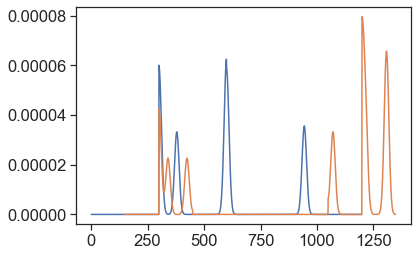

In [151]:
plt.plot(store_g1_p1[0])
plt.plot(store_g2_p1[1])

In [152]:
12000/150

80.0

In [153]:
790/8

98.75

In [154]:
150

150

In [155]:
def get_mean_activity_matrix(single_trial_resps,order=None,half=0,downsample_factor=150,smoothing_factor=10,flip=False):
    
    """ This builds a matrix by concatenating mean population activity centered on each
        of the different pokes that describes how things evolve over time.
    """
    
    if order is None:
        order = np.arange(9)

    n_units = len(single_trial_resps)
    store_g1 = []
    
    downsample_axis = int(np.floor(len(single_trial_resps[4][3][0])/downsample_factor))
    #print(downsample_axis)
    for neuron_ix in range(n_units):
        tmp = [] 
        for poke_nr in order:
            activity = np.array(single_trial_resps[neuron_ix][poke_nr])
            #print(np.sum(activity))
            if half==0:
                mean_activity = np.mean(activity,axis=0)
            elif half==1:
                mean_activity = np.mean(activity[:int(len(activity)/2)],axis=0)
            elif half==2:
                mean_activity = np.mean(activity[int(len(activity)/2):],axis=0)
                
            try:
                mean_downsampled = mean_activity.reshape(-1,downsample_axis).mean(axis=1)
                #print(mean_downsampled.shape)
                mean_downsampled_smoothed = gaussian_filter1d(mean_downsampled,smoothing_factor)
            except ValueError:
                mean_downsampled_smoothed = np.zeros(downsample_factor) + np.nan
            
            if flip: mean_downsampled_smoothed = np.flipud(mean_downsampled_smoothed)
            tmp.append(mean_downsampled_smoothed)
            
        #print(np.array(tmp).shape)
        store_g1.append(np.hstack(tmp))
    return np.array(store_g1)

In [156]:
store_g1_p1.shape

(313, 1350)

In [157]:
9*150

1350

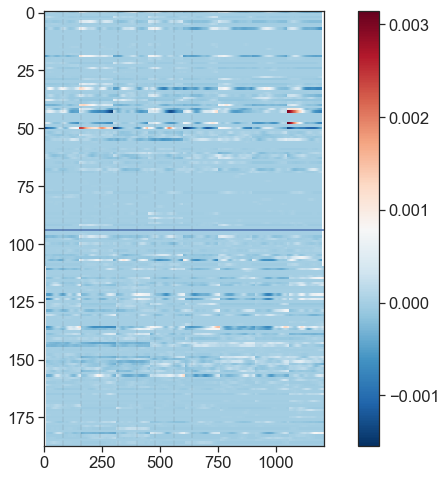

In [158]:
plt.figure(figsize=(12,8))
conditions =  np.logical_and.reduce([ccs_across<99,
                                    ccs_within>=.8])

tmp_stack = np.vstack([store_g1_p1[:,:-140],store_g2_p1[:,140:]])
tmp_stack = tmp_stack - np.nanmean(tmp_stack,axis=1)[:,None]
tmp_stack = tmp_stack[np.repeat(conditions,2)]
plt.imshow(tmp_stack,cmap='RdBu_r',interpolation='None',aspect=10)
current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='red')
plt.axhline(y=sum(conditions))


C = np.empty((store_g1_p1.shape[0]+store_g2_p1.shape[0],store_g1_p1.shape[1]))

C[::2,:] = store_g1_p1
C[1::2,:] = store_g2_p1


for ii in range(9):
    plt.axvline(x=ii*80,linestyle='--',color='.3',alpha=.1)
#plt.ylim(100,0)
plt.colorbar()

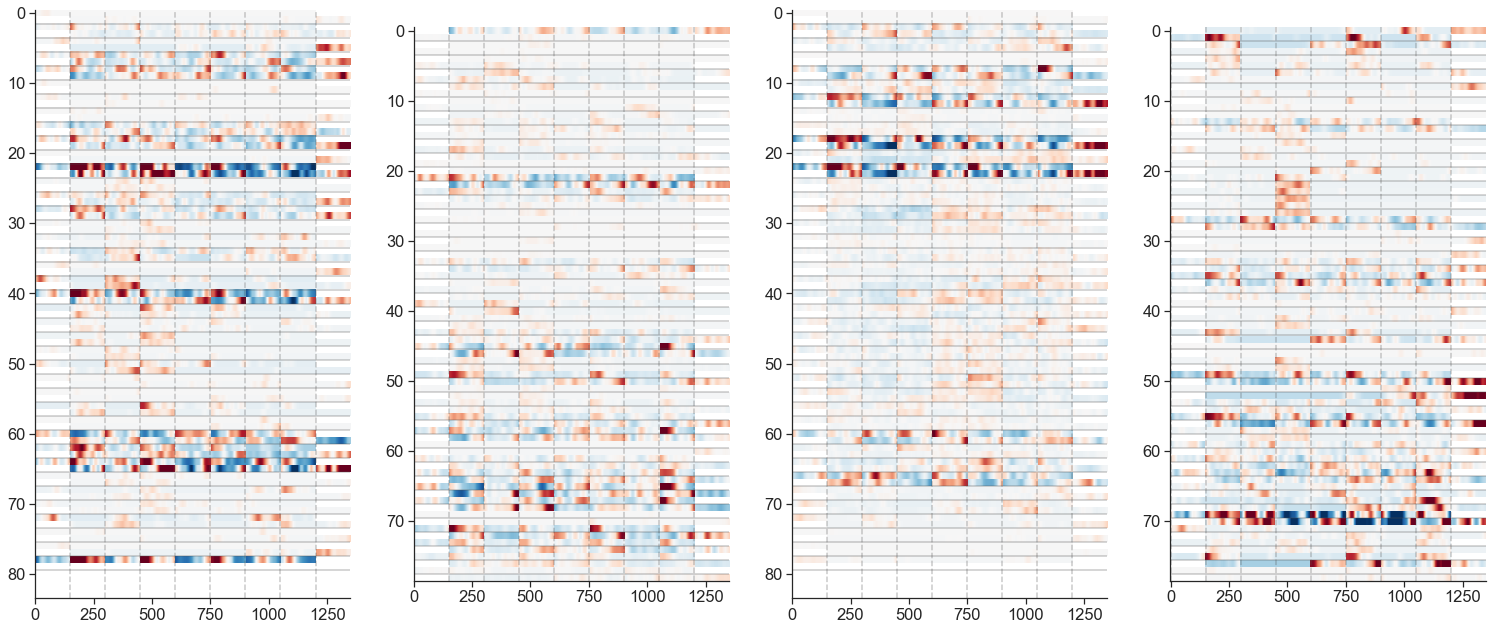

In [159]:
plt.figure(figsize=(26,12))

NSEGMENT = 4
conditions =  np.logical_and.reduce([ccs_across<99,
                                    ccs_within>=.5])

tmp_stack = np.vstack([store_g1_p1[:,:-140],store_g2_p1[:,140:]])
tmp_stack = tmp_stack - np.nanmean(tmp_stack,axis=1)[:,None]
tmp_stack = tmp_stack[np.repeat(conditions,2)]


C = np.zeros([2*sum(conditions),store_g1_p1.shape[1]])

C[::2,:] = store_g1_p1[conditions] - np.nanmean(store_g1_p1[conditions],axis=1)[:,None]
C[1::2,:] = store_g2_p1[conditions]- np.nanmean(store_g2_p1[conditions],axis=1)[:,None]


for im in range(NSEGMENT):
    plt.subplot(1,NSEGMENT,im+1)
    cplot = C[int(im*len(C)/NSEGMENT):int((im+1)*len(C)/NSEGMENT)]
    mx= .5*np.max(np.abs([np.nanmin(cplot),np.nanmax(cplot)]))
    plt.imshow(cplot,cmap='RdBu_r',interpolation='None',aspect=30,vmin=-mx,vmax=mx)
    current_cmap = plt.cm.get_cmap()
    current_cmap.set_bad(color='red')

    ctr = 0
    for ii in range(int(im*len(C)/NSEGMENT),int((im+1)*len(C)/NSEGMENT)):
        if np.remainder(ii,2)==0:
            plt.axhline(y=2*ctr+1.5,linestyle='-',color='.3',alpha=.3)
            ctr+= 1
    for ii in range(9):
        plt.axvline(x=ii*150,linestyle='--',color='.3',alpha=.3)
#plt.ylim(50,0)
#plt.colorbar()
seaborn.despine()

In [26]:
1580/18

87.77777777777777

In [21]:
np.hstack([store_g1_p1,store_g2_p1]).shape

(313, 1580)

In [ ]:
sto